In [426]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [427]:
#Open the csv files
file_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
df_train = pd.read_csv(file_path)

file_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
df_test = pd.read_csv(file_path)

#Concatenate both dataframes to avoid doing the data cleaning both time.
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

<Axes: >

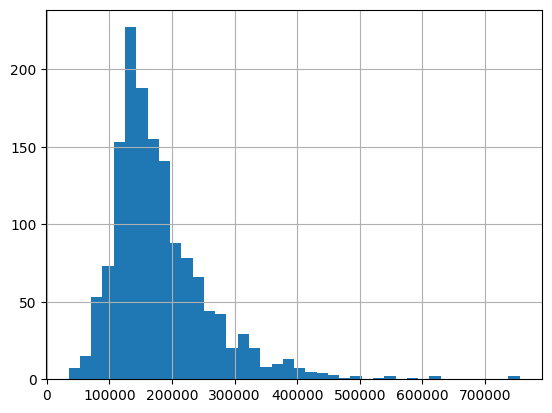

In [428]:
df_train['SalePrice'].hist(bins = 40)

### Data visualization

In [429]:
#Shape of the dataset
rows,columns = df_all.shape
str(rows) + " lines and " + str(columns) + " columns"

'2919 lines and 81 columns'

In [430]:
df_all.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


### Exploratory analysis

In [431]:
#We select all the categorical features with less than 10 unique values.
categorical_cols = [cname for cname in df_train.columns if df_train[cname].nunique() < 10 and df_train[cname].dtype == "object"]
print(categorical_cols)
print(len(categorical_cols))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
40


In [432]:
"""
for column in categorical_cols:
    fig, axs = plt.subplots(1, 2, figsize=(6, 2))
    
    # Plot the percentage on the first subplot
    sns.histplot(x=column, data=df_train, stat='percent', ax=axs[0])
    axs[0].set_ylim(0, 100)
    axs[0].set_title(f'Percentage of {column}')
    
    # Plot the frequency on the second subplot
    sns.histplot(x=column, data=df_train, stat='count', ax=axs[1])
    axs[1].set_ylim(0, 2919)
    axs[1].set_title(f'Frequency of {column}')
    
    plt.tight_layout()
    plt.show()
    """

"\nfor column in categorical_cols:\n    fig, axs = plt.subplots(1, 2, figsize=(6, 2))\n    \n    # Plot the percentage on the first subplot\n    sns.histplot(x=column, data=df_train, stat='percent', ax=axs[0])\n    axs[0].set_ylim(0, 100)\n    axs[0].set_title(f'Percentage of {column}')\n    \n    # Plot the frequency on the second subplot\n    sns.histplot(x=column, data=df_train, stat='count', ax=axs[1])\n    axs[1].set_ylim(0, 2919)\n    axs[1].set_title(f'Frequency of {column}')\n    \n    plt.tight_layout()\n    plt.show()\n    "

We can see that some of those features have a very high proportion of NaN.

And some of the remaining features have a very high proportion of only one value.

Those features will be identified and removed from the dataset later.

In [433]:
#We select all the numerical features.
numerical_cols = [cname for cname in df_train.columns if df_train[cname].dtype in ['int64', 'float64']]
numerical_cols.remove('Id')
numerical_cols.remove('SalePrice')
print(numerical_cols)
print(len(numerical_cols))

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
36


In [434]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


We can see that some of those features have a very high difference between their 75% quantiles and their max values. This indicated that some of those features have outliers.

Those outliers will be removed from the dataset later.

<Axes: >

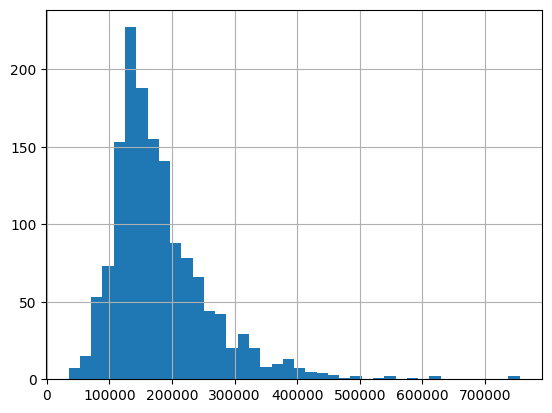

In [435]:
#Show the distribution of the SalePrice target
df_train['SalePrice'].hist(bins = 40)

The distribution of the target is not evenly distributed. We will have to fix that later.

In [436]:
#Display the NaN
nanTotal = df_train.isnull().sum().sum()
print("\nThe dataset contains " + str(nanTotal) + " missing data for " + str(df_train.size) + ". Which is " + str(round(100*(nanTotal / (rows * columns)),2)) + " % of the total data\n")
print("Number of data missing per columns:")
colsWithNan = [col for col in df_train.columns if df_train[col].isnull().sum() > 0]
for col in colsWithNan:
    print(col + ": " + str(df_train[col].isnull().sum()) + " which is " + str(round(100*(df_train[col].isnull().sum()/rows),2)) + " % of the total of that column")


The dataset contains 7829 missing data for 118260. Which is 3.31 % of the total data

Number of data missing per columns:
LotFrontage: 259 which is 8.87 % of the total of that column
Alley: 1369 which is 46.9 % of the total of that column
MasVnrType: 872 which is 29.87 % of the total of that column
MasVnrArea: 8 which is 0.27 % of the total of that column
BsmtQual: 37 which is 1.27 % of the total of that column
BsmtCond: 37 which is 1.27 % of the total of that column
BsmtExposure: 38 which is 1.3 % of the total of that column
BsmtFinType1: 37 which is 1.27 % of the total of that column
BsmtFinType2: 38 which is 1.3 % of the total of that column
Electrical: 1 which is 0.03 % of the total of that column
FireplaceQu: 690 which is 23.64 % of the total of that column
GarageType: 81 which is 2.77 % of the total of that column
GarageYrBlt: 81 which is 2.77 % of the total of that column
GarageFinish: 81 which is 2.77 % of the total of that column
GarageQual: 81 which is 2.77 % of the total of

A lot of those features have missing values. 

It most of the time means that the object of the feature doesn't exist (ie FirePlaceQu is null when there are no fireplaces)

Some of the categorical features missing values will be replaced by numerical features to reflect their classifier status.
For example BsmtCond which describe the general condition of the basement will be transformed into a numerical with lower number representing a bad condition and higer numbers a better condition of the basement.

### Data cleaning

In [437]:
#We replace some categorical features into numerical features
df_train['BsmtCond'] = df_train['BsmtCond'].fillna('NaN')
mapping_BsmtCond = {'NaN': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df_train['BsmtCond'] = df_train['BsmtCond'].map(mapping_BsmtCond)

df_train['BsmtExposure'] = df_train['BsmtExposure'].fillna('NaN')
mapping_BsmtExposure = {'NaN': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
df_train['BsmtExposure'] = df_train['BsmtExposure'].map(mapping_BsmtExposure)

df_train['BsmtQual'] = df_train['BsmtQual'].fillna('NaN')
mapping_BsmtQual = {'NaN': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df_train['BsmtQual'] = df_train['BsmtQual'].map(mapping_BsmtQual)

df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('NaN')
mapping_FireplaceQu = {'NaN': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df_train['FireplaceQu'] = df_train['FireplaceQu'].map(mapping_FireplaceQu)

df_train['GarageCond'] = df_train['GarageCond'].fillna('NaN')
mapping_GarageCond = {'NaN': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df_train['GarageCond'] = df_train['GarageCond'].map(mapping_GarageCond)

df_train['GarageFinish'] = df_train['GarageFinish'].fillna('NaN')
mapping_GarageFinish = {'NaN': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
df_train['GarageFinish'] = df_train['GarageFinish'].map(mapping_GarageFinish)

df_train['GarageQual'] = df_train['GarageQual'].fillna('NaN')
mapping_GarageQual = {'NaN': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df_train['GarageQual'] = df_train['GarageQual'].map(mapping_GarageQual)

In [438]:
#Adding new features.

df_train['TotalSF']=df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_train['Total_sqr_footage'] = (df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] + df_train['1stFlrSF'] + df_train['2ndFlrSF'])
df_train['Total_Bathrooms'] = (df_train['FullBath'] + (0.5 * df_train['HalfBath']) + df_train['BsmtFullBath'] + (0.5 * df_train['BsmtHalfBath']))
df_train['Total_porch_sf'] = (df_train['OpenPorchSF'] + df_train['3SsnPorch'] + df_train['EnclosedPorch'] + df_train['ScreenPorch'] + df_train['WoodDeckSF'])

In [439]:
#Selecting the categorical data that are not more than 90% NaN and more than 95% the same value
categorical_cols = [cname for cname in df_train.columns if df_train[cname].nunique() < 10 and df_train[cname].dtype == "object"]
cat_cols_to_keep = []

for col in categorical_cols:
    if df_train[col].isna().sum() / len(df_train) < 0.9:
        if df_train[col].nunique() > 1:
            if (df_train[col].value_counts() / len(df_train)).max() < 0.95:
                cat_cols_to_keep.append(col)
                
print(cat_cols_to_keep)
print(len(cat_cols_to_keep))

['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
25


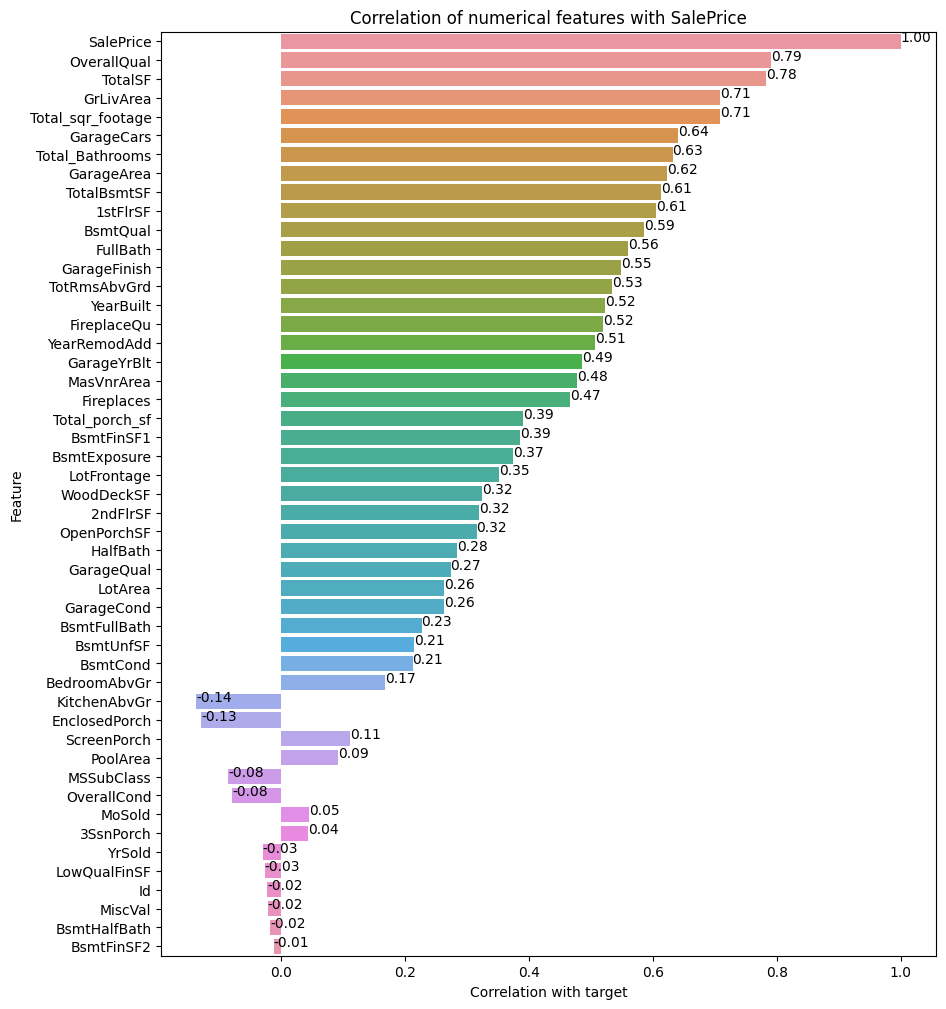

In [440]:
#Visualizing the correlation between the numerical data and the SalePrice target

numerical_cols = [cname for cname in df_train.columns if df_train[cname].dtype in ['int64', 'float64']]
df_temp = df_train[numerical_cols]
corr = df_temp.corr()
SalePriceCorr = corr['SalePrice']

# Create a DataFrame for better visualization
corr_df = pd.DataFrame(SalePriceCorr)
corr_df.reset_index(inplace=True)
corr_df.columns = ['Feature', 'Correlation with target']

# Sort by absolute value
corr_df['Abs Correlation'] = corr_df['Correlation with target'].abs()
sorted_corr_df = corr_df.sort_values('Abs Correlation', ascending=False)

# Plotting
plt.figure(figsize=(10,12))
barplot = sns.barplot(data=sorted_corr_df, y='Feature', x='Correlation with target', orient='h')
plt.title('Correlation of numerical features with SalePrice')

# Add the correlation values on each bar
for p in barplot.patches:
    width = p.get_width()
    plt.text(width,  
             p.get_y() + p.get_height() / 2,
             '{:1.2f}'.format(width), 
             ha = 'left')

plt.show()

In [441]:
#We remove all the features for which the correlation is lower than 20%
num_cols_to_keep = [col for col in df_train[numerical_cols] if abs(SalePriceCorr[col]) > 0.2]

print(num_cols_to_keep)
print(len(num_cols_to_keep))

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'TotalSF', 'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf']
34


In [442]:
#We will now remove the outliers in the numerical features of the training dataframe using IQR
print(df_train.shape)
for col in num_cols_to_keep:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    if Q1 != Q3 and Q1 != 0:
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_train = df_train[(df_train[col] >= lower_bound) & (df_train[col] <= upper_bound)]
print(df_train.shape)

(1460, 85)
(802, 85)


In [443]:
#Aggregating the new dataframe
cols_to_keep = cat_cols_to_keep + num_cols_to_keep

print(cols_to_keep)
print(len(cols_to_keep))

#replacing the dataframe with the selected column
df_train = df_train[cols_to_keep]
print(df_train.shape)

['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'TotalSF', 'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf']
59
(802, 59)


In [444]:
#removing the rows for which a NaN as been found, but only when there is less than 5 NaN in the column.
nan_counts = df_train.isna().sum()
cols_to_check = nan_counts[nan_counts < 5].index.tolist()

for col in cols_to_check:
    df_train = df_train[df_train[col].notna()]
print(df_train.shape)

(801, 59)


In [445]:
#Filling the remaining columns
df_train['BsmtFinType1']= df_train['BsmtFinType1'].fillna('missing')
df_train['BsmtFinType2']= df_train['BsmtFinType2'].fillna('missing')
df_train['GarageType']= df_train['GarageType'].fillna('missing')
df_train['LotFrontage']= df_train['LotFrontage'].fillna(0)
df_train['MasVnrArea']= df_train['MasVnrArea'].fillna(0)
df_train['MasVnrType']= df_train['MasVnrType'].fillna('missing')
df_train['Fence']= df_train['Fence'].fillna('missing')
df_train['GarageYrBlt']= df_train['GarageYrBlt'].fillna('missing')

In [446]:
#Display the NaN from the new dataframe
nanTotal = df_train.isnull().sum().sum()
print("\nThe dataset contains " + str(nanTotal) + " missing data for " + str(df_train.size) + ". Which is " + str(round(100*(nanTotal / (rows * columns)),2)) + " % of the total data\n")
print("Number of data missing per columns:")
colsWithNan = [col for col in df_train.columns if df_train[col].isnull().sum() > 0]
for col in colsWithNan:
    print(col + ": " + str(df_train[col].isnull().sum()) + " which is " + str(round(100*(df_train[col].isnull().sum()/rows),2)) + " % of the total of that column")


The dataset contains 0 missing data for 47259. Which is 0.0 % of the total data

Number of data missing per columns:


In [447]:
#We split the train dataframe into target and features
X_raw = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

<Axes: >

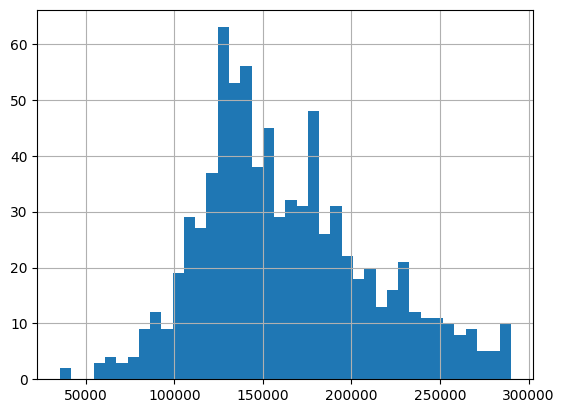

In [448]:
#Checking the distribution of the SalePrice target
y.hist(bins = 40)

It seems that removing the outliers already fixed the skewness issue we had.

In [449]:
#Encoding of categorical variable. We will use a random forest model so we keep all the dummies.
X = pd.get_dummies(X_raw)

In [450]:
# Separate into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

### Model training

In [451]:
#Create the XGBoost model and fit it using a GridSearchCV

#Create the hyperparameter grid for the GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [5, 10, 20]
}

xgb = XGBRegressor(learning_rate=0.02, n_estimators=600, silent=True, nthread=1, random_state=0)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_log_error', n_jobs=4)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_predic = best_model.predict(X_valid)

[09:13:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

{'learning_rate': 0.5, 'n_estimators': 10}


In [452]:
#Predict and calculate the RMSLE
y_predic = best_model.predict(X_valid)
clf_rmsle = np.sqrt(mean_squared_log_error(y_predic, y_valid))
print(clf_rmsle.round(4))

0.1139
[09:09:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:09:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:09:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:09:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:09:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:09:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:12:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:12:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:12:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:12:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:12:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[09:12:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } 

We got an RMSLE of 0.1139. In the kaggle competition from which this dataset has been taken, this would put us in 80th position out of 4707 contestant.